In [1]:
import tensorflow as tf
from tensorflow import keras
print(tf.version.VERSION)

2.3.0


In [2]:
print('Num GPUs Available: ', len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
#Importing files and defining dimension of image

width=256
height=256
channels=3

import tensorflow as tf
import os
import numpy as np
import random
from tqdm import tqdm
from PIL import Image
import cv2
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.transform import resize
import matplotlib.pyplot as plt
from load_data import load_path, get_data, shuffling

seed=42
np.random.seed=seed

In [4]:
#Defining path and getting ids of images
train_path='Preprocessed/Train/Image'
train_mask_path='Preprocessed/Train/Mask'
test_path='Preprocessed/Test/Image'
test_mask_path='Preprocessed/Test/Mask'

train_ids, train_mask_ids, test_ids, test_mask_ids = load_path(train_path, train_mask_path, test_path, test_mask_path)

In [5]:
#loding train and test images and randomly shuffling it
X_train, Y_train = get_data(train_path, train_mask_path, train_ids, train_mask_ids, height, width)
X_test, Y_test = get_data(test_path, test_mask_path, test_ids, test_mask_ids, height, width)
X_train, Y_train = shuffling(X_train, Y_train)
X_test, Y_test = shuffling(X_test, Y_test)

100%|██████████| 20/20 [00:00<00:00, 440.30it/s]


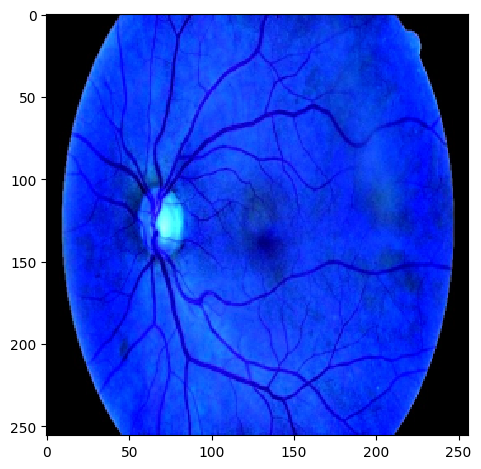

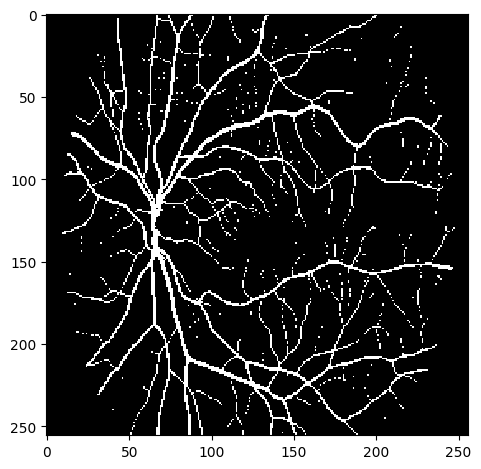

In [6]:
#testing train
img_x=random.randint(0, len(train_ids))
imshow(X_train[img_x])
plt.show()
imshow(Y_train[img_x])
plt.show()

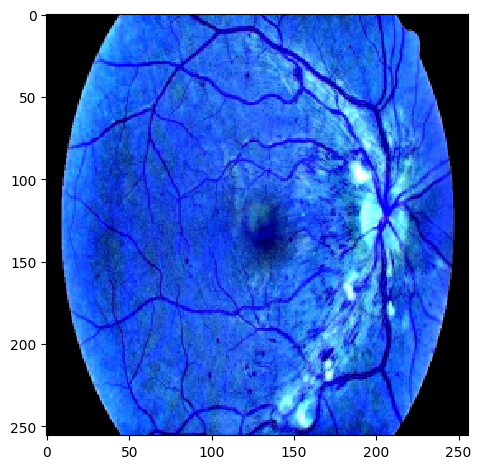

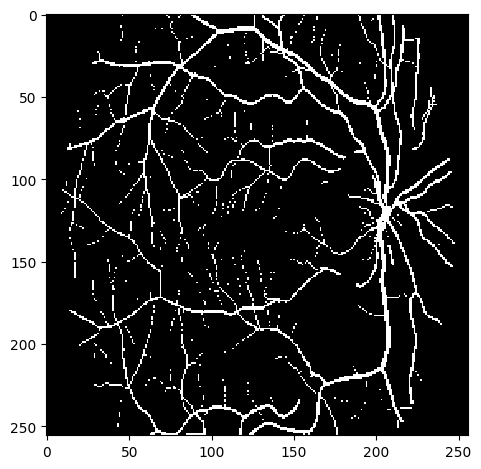

In [7]:
#testing test
img_x=random.randint(0, len(test_ids)-1)
imshow(X_test[img_x])
plt.show()
imshow(Y_test[img_x])
plt.show()

In [8]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy, Recall, Precision
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from Metrics import dice_coef, dice_loss, iou

In [9]:
#Defining parameters
batch_size = 4
lr = 1e-3
num_epochs = 200
model_path = os.path.join('preprocessd_model.h5')
csv_path = os.path.join('preprocessed_data.csv')

In [10]:
#Input Layer
input=tf.keras.layers.Input((width, height, channels))

In [11]:
#Contraction
c1=tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(input)
c1=tf.keras.layers.Dropout(0.1)(c1)
c1=tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1=tf.keras.layers.MaxPooling2D((2,2))(c1)

c2=tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2=tf.keras.layers.Dropout(0.1)(c2)
c2=tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2=tf.keras.layers.MaxPooling2D((2,2))(c2)

c3=tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3=tf.keras.layers.Dropout(0.2)(c3)
c3=tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3=tf.keras.layers.MaxPooling2D((2,2))(c3)

c4=tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4=tf.keras.layers.Dropout(0.2)(c4)
c4=tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4=tf.keras.layers.MaxPooling2D((2,2))(c4)

c5=tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5=tf.keras.layers.Dropout(0.3)(c5)
c5=tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

In [12]:
#Expansion
u6=tf.keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
u6=tf.keras.layers.concatenate([u6,c4])
c6=tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6=tf.keras.layers.Dropout(0.2)(c6)
c6=tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7=tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
u7=tf.keras.layers.concatenate([u7,c3])
c7=tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7=tf.keras.layers.Dropout(0.2)(c7)
c7=tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8=tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
u8=tf.keras.layers.concatenate([u8,c2])
c8=tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8=tf.keras.layers.Dropout(0.1)(c8)
c8=tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9=tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
u9=tf.keras.layers.concatenate([u9,c1])
c9=tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9=tf.keras.layers.Dropout(0.1)(c9)
c9=tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

In [13]:
#Output Layer
output=tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(c9)

In [14]:
#Model
model=tf.keras.Model(inputs=[input], outputs=[output])
model.compile(optimizer=Adam(lr), loss=dice_loss, metrics=[dice_coef, iou, Accuracy(), Recall(), Precision()])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        dropout[0][0]                    
_______________________________________________________________________________________

In [15]:
#Model Checkpoint
checkpointer=tf.keras.callbacks.ModelCheckpoint('model_for_retina', verbose=1,save_best_only=True)

callbacks=[
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=1000, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    CSVLogger(csv_path),
    
]

results=model.fit(X_train, Y_train, validation_split = 0.1, batch_size = batch_size, epochs = num_epochs, callbacks=callbacks)

Epoch 1/200
 1/17 [>.............................] - ETA: 0s - loss: 0.8477 - dice_coef: 0.1523 - iou: 0.0824 - accuracy: 0.0000e+00 - recall: 0.1255 - precision: 0.0968WARNING:tensorflow:From C:\Users\User\.conda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
17/17 [==============================] - ETA: 0s - loss: 0.8212 - dice_coef: 0.1771 - iou: 0.0973 - accuracy: 0.0084 - recall: 0.7957 - precision: 0.1055  
Epoch 00001: val_loss improved from inf to 0.78592, saving model to preprocessd_model.h5
17/17 [==============================] - 5s 320ms/step - loss: 0.8212 - dice_coef: 0.1771 - iou: 0.0973 - accuracy: 0.0084 - recall: 0.7957 - precision: 0.1055 - val_loss: 0.7859 - val_dice_coef: 0.2141 - val_iou: 0.1199 - val_accuracy: 0.0933 - val_recall: 1.0000 - val_precision: 0.1212
Epo

Epoch 15/200
17/17 [==============================] - ETA: 0s - loss: 0.7762 - dice_coef: 0.2236 - iou: 0.1260 - accuracy: 0.4946 - recall: 0.7849 - precision: 0.1307
Epoch 00015: val_loss did not improve from 0.74880
17/17 [==============================] - 1s 64ms/step - loss: 0.7762 - dice_coef: 0.2236 - iou: 0.1260 - accuracy: 0.4946 - recall: 0.7849 - precision: 0.1307 - val_loss: 0.7582 - val_dice_coef: 0.2418 - val_iou: 0.1375 - val_accuracy: 0.4468 - val_recall: 0.8293 - val_precision: 0.1416
Epoch 16/200
17/17 [==============================] - ETA: 0s - loss: 0.7774 - dice_coef: 0.2214 - iou: 0.1246 - accuracy: 0.5160 - recall: 0.7404 - precision: 0.1319
Epoch 00016: val_loss did not improve from 0.74880
17/17 [==============================] - 1s 46ms/step - loss: 0.7774 - dice_coef: 0.2214 - iou: 0.1246 - accuracy: 0.5160 - recall: 0.7404 - precision: 0.1319 - val_loss: 0.7536 - val_dice_coef: 0.2464 - val_iou: 0.1405 - val_accuracy: 0.5264 - val_recall: 0.7317 - val_precis

17/17 [==============================] - ETA: 0s - loss: 0.7745 - dice_coef: 0.2234 - iou: 0.1260 - accuracy: 0.5687 - recall: 0.6876 - precision: 0.1347
Epoch 00031: val_loss did not improve from 0.74880
17/17 [==============================] - 1s 43ms/step - loss: 0.7745 - dice_coef: 0.2234 - iou: 0.1260 - accuracy: 0.5687 - recall: 0.6876 - precision: 0.1347 - val_loss: 0.7533 - val_dice_coef: 0.2467 - val_iou: 0.1407 - val_accuracy: 0.5683 - val_recall: 0.6824 - val_precision: 0.1505
Epoch 32/200
17/17 [==============================] - ETA: 0s - loss: 0.7723 - dice_coef: 0.2257 - iou: 0.1274 - accuracy: 0.5684 - recall: 0.6984 - precision: 0.1361
Epoch 00032: val_loss did not improve from 0.74880
17/17 [==============================] - 1s 43ms/step - loss: 0.7723 - dice_coef: 0.2257 - iou: 0.1274 - accuracy: 0.5684 - recall: 0.6984 - precision: 0.1361 - val_loss: 0.7620 - val_dice_coef: 0.2380 - val_iou: 0.1351 - val_accuracy: 0.6193 - val_recall: 0.5737 - val_precision: 0.1505
E

17/17 [==============================] - ETA: 0s - loss: 0.8074 - dice_coef: 0.1949 - iou: 0.1096 - accuracy: 0.5824 - recall: 0.6022 - precision: 0.1298
Epoch 00047: val_loss did not improve from 0.74028
17/17 [==============================] - 1s 43ms/step - loss: 0.8074 - dice_coef: 0.1949 - iou: 0.1096 - accuracy: 0.5824 - recall: 0.6022 - precision: 0.1298 - val_loss: 0.7569 - val_dice_coef: 0.2431 - val_iou: 0.1384 - val_accuracy: 0.4216 - val_recall: 0.8420 - val_precision: 0.1419
Epoch 48/200
17/17 [==============================] - ETA: 0s - loss: 0.7695 - dice_coef: 0.2334 - iou: 0.1323 - accuracy: 0.5709 - recall: 0.5563 - precision: 0.1459
Epoch 00048: val_loss did not improve from 0.74028
17/17 [==============================] - 1s 54ms/step - loss: 0.7695 - dice_coef: 0.2334 - iou: 0.1323 - accuracy: 0.5709 - recall: 0.5563 - precision: 0.1459 - val_loss: 0.7872 - val_dice_coef: 0.2128 - val_iou: 0.1193 - val_accuracy: 0.4953 - val_recall: 0.2537 - val_precision: 0.1955
E

17/17 [==============================] - ETA: 0s - loss: 0.3328 - dice_coef: 0.6664 - iou: 0.4999 - accuracy: 0.2016 - recall: 0.6564 - precision: 0.6864
Epoch 00062: val_loss improved from 0.30684 to 0.30292, saving model to preprocessd_model.h5
17/17 [==============================] - 1s 83ms/step - loss: 0.3328 - dice_coef: 0.6664 - iou: 0.4999 - accuracy: 0.2016 - recall: 0.6564 - precision: 0.6864 - val_loss: 0.3029 - val_dice_coef: 0.6971 - val_iou: 0.5351 - val_accuracy: 0.2240 - val_recall: 0.6672 - val_precision: 0.7349
Epoch 63/200
17/17 [==============================] - ETA: 0s - loss: 0.3288 - dice_coef: 0.6703 - iou: 0.5048 - accuracy: 0.2031 - recall: 0.6571 - precision: 0.6923
Epoch 00063: val_loss did not improve from 0.30292
17/17 [==============================] - 1s 47ms/step - loss: 0.3288 - dice_coef: 0.6703 - iou: 0.5048 - accuracy: 0.2031 - recall: 0.6571 - precision: 0.6923 - val_loss: 0.3102 - val_dice_coef: 0.6898 - val_iou: 0.5265 - val_accuracy: 0.1403 - va

Epoch 78/200
17/17 [==============================] - ETA: 0s - loss: 0.2950 - dice_coef: 0.7017 - iou: 0.5412 - accuracy: 0.1970 - recall: 0.6893 - precision: 0.7283
Epoch 00078: val_loss did not improve from 0.27167
17/17 [==============================] - 1s 46ms/step - loss: 0.2950 - dice_coef: 0.7017 - iou: 0.5412 - accuracy: 0.1970 - recall: 0.6893 - precision: 0.7283 - val_loss: 0.2829 - val_dice_coef: 0.7171 - val_iou: 0.5589 - val_accuracy: 0.1814 - val_recall: 0.6304 - val_precision: 0.8353
Epoch 79/200
17/17 [==============================] - ETA: 0s - loss: 0.2986 - dice_coef: 0.6971 - iou: 0.5357 - accuracy: 0.1186 - recall: 0.6797 - precision: 0.7313
Epoch 00079: val_loss did not improve from 0.27167
17/17 [==============================] - 2s 119ms/step - loss: 0.2986 - dice_coef: 0.6971 - iou: 0.5357 - accuracy: 0.1186 - recall: 0.6797 - precision: 0.7313 - val_loss: 0.2852 - val_dice_coef: 0.7148 - val_iou: 0.5562 - val_accuracy: 0.1485 - val_recall: 0.6446 - val_preci

Epoch 94/200
17/17 [==============================] - ETA: 0s - loss: 0.2733 - dice_coef: 0.7234 - iou: 0.5675 - accuracy: 0.2299 - recall: 0.7146 - precision: 0.7447
Epoch 00094: val_loss did not improve from 0.24993
17/17 [==============================] - 1s 87ms/step - loss: 0.2733 - dice_coef: 0.7234 - iou: 0.5675 - accuracy: 0.2299 - recall: 0.7146 - precision: 0.7447 - val_loss: 0.2661 - val_dice_coef: 0.7339 - val_iou: 0.5796 - val_accuracy: 0.2001 - val_recall: 0.6431 - val_precision: 0.8584
Epoch 95/200
17/17 [==============================] - ETA: 0s - loss: 0.2769 - dice_coef: 0.7250 - iou: 0.5692 - accuracy: 0.2224 - recall: 0.7020 - precision: 0.7517
Epoch 00095: val_loss did not improve from 0.24993
17/17 [==============================] - 1s 43ms/step - loss: 0.2769 - dice_coef: 0.7250 - iou: 0.5692 - accuracy: 0.2224 - recall: 0.7020 - precision: 0.7517 - val_loss: 0.2504 - val_dice_coef: 0.7496 - val_iou: 0.5994 - val_accuracy: 0.2101 - val_recall: 0.7023 - val_precis

Epoch 110/200
17/17 [==============================] - ETA: 0s - loss: 0.2544 - dice_coef: 0.7452 - iou: 0.5940 - accuracy: 0.1922 - recall: 0.7278 - precision: 0.7686
Epoch 00110: val_loss did not improve from 0.22703
17/17 [==============================] - 1s 86ms/step - loss: 0.2544 - dice_coef: 0.7452 - iou: 0.5940 - accuracy: 0.1922 - recall: 0.7278 - precision: 0.7686 - val_loss: 0.2339 - val_dice_coef: 0.7661 - val_iou: 0.6209 - val_accuracy: 0.1896 - val_recall: 0.7161 - val_precision: 0.8272
Epoch 111/200
17/17 [==============================] - ETA: 0s - loss: 0.2512 - dice_coef: 0.7487 - iou: 0.5987 - accuracy: 0.2279 - recall: 0.7296 - precision: 0.7742
Epoch 00111: val_loss did not improve from 0.22703
17/17 [==============================] - 1s 55ms/step - loss: 0.2512 - dice_coef: 0.7487 - iou: 0.5987 - accuracy: 0.2279 - recall: 0.7296 - precision: 0.7742 - val_loss: 0.2333 - val_dice_coef: 0.7667 - val_iou: 0.6216 - val_accuracy: 0.1776 - val_recall: 0.7016 - val_prec

Epoch 126/200
17/17 [==============================] - ETA: 0s - loss: 0.2377 - dice_coef: 0.7647 - iou: 0.6194 - accuracy: 0.2086 - recall: 0.7385 - precision: 0.7903
Epoch 00126: val_loss improved from 0.22071 to 0.21633, saving model to preprocessd_model.h5
17/17 [==============================] - 2s 109ms/step - loss: 0.2377 - dice_coef: 0.7647 - iou: 0.6194 - accuracy: 0.2086 - recall: 0.7385 - precision: 0.7903 - val_loss: 0.2163 - val_dice_coef: 0.7837 - val_iou: 0.6443 - val_accuracy: 0.1574 - val_recall: 0.7577 - val_precision: 0.8134
Epoch 127/200
17/17 [==============================] - ETA: 0s - loss: 0.2349 - dice_coef: 0.7648 - iou: 0.6195 - accuracy: 0.1985 - recall: 0.7488 - precision: 0.7858
Epoch 00127: val_loss did not improve from 0.21633
17/17 [==============================] - 1s 72ms/step - loss: 0.2349 - dice_coef: 0.7648 - iou: 0.6195 - accuracy: 0.1985 - recall: 0.7488 - precision: 0.7858 - val_loss: 0.2203 - val_dice_coef: 0.7797 - val_iou: 0.6390 - val_accur

Epoch 142/200
17/17 [==============================] - ETA: 0s - loss: 0.2293 - dice_coef: 0.7715 - iou: 0.6282 - accuracy: 0.1503 - recall: 0.7517 - precision: 0.7943
Epoch 00142: val_loss did not improve from 0.21236
17/17 [==============================] - 2s 95ms/step - loss: 0.2293 - dice_coef: 0.7715 - iou: 0.6282 - accuracy: 0.1503 - recall: 0.7517 - precision: 0.7943 - val_loss: 0.2153 - val_dice_coef: 0.7847 - val_iou: 0.6457 - val_accuracy: 0.0962 - val_recall: 0.7619 - val_precision: 0.8105
Epoch 143/200
17/17 [==============================] - ETA: 0s - loss: 0.2286 - dice_coef: 0.7705 - iou: 0.6270 - accuracy: 0.2128 - recall: 0.7559 - precision: 0.7906
Epoch 00143: val_loss did not improve from 0.21236
17/17 [==============================] - 1s 84ms/step - loss: 0.2286 - dice_coef: 0.7705 - iou: 0.6270 - accuracy: 0.2128 - recall: 0.7559 - precision: 0.7906 - val_loss: 0.2158 - val_dice_coef: 0.7842 - val_iou: 0.6450 - val_accuracy: 0.1660 - val_recall: 0.7324 - val_prec

Epoch 158/200
17/17 [==============================] - ETA: 0s - loss: 0.2187 - dice_coef: 0.7796 - iou: 0.6392 - accuracy: 0.1681 - recall: 0.7678 - precision: 0.7984
Epoch 00158: val_loss did not improve from 0.20763
17/17 [==============================] - 1s 67ms/step - loss: 0.2187 - dice_coef: 0.7796 - iou: 0.6392 - accuracy: 0.1681 - recall: 0.7678 - precision: 0.7984 - val_loss: 0.2115 - val_dice_coef: 0.7885 - val_iou: 0.6509 - val_accuracy: 0.0904 - val_recall: 0.7386 - val_precision: 0.8473
Epoch 159/200
17/17 [==============================] - ETA: 0s - loss: 0.2195 - dice_coef: 0.7801 - iou: 0.6396 - accuracy: 0.1599 - recall: 0.7646 - precision: 0.7996
Epoch 00159: val_loss did not improve from 0.20763
17/17 [==============================] - 1s 53ms/step - loss: 0.2195 - dice_coef: 0.7801 - iou: 0.6396 - accuracy: 0.1599 - recall: 0.7646 - precision: 0.7996 - val_loss: 0.2135 - val_dice_coef: 0.7865 - val_iou: 0.6481 - val_accuracy: 0.1387 - val_recall: 0.7361 - val_prec

Epoch 174/200
17/17 [==============================] - ETA: 0s - loss: 0.2146 - dice_coef: 0.7836 - iou: 0.6445 - accuracy: 0.1865 - recall: 0.7683 - precision: 0.8053
Epoch 00174: val_loss did not improve from 0.20703
17/17 [==============================] - 2s 93ms/step - loss: 0.2146 - dice_coef: 0.7836 - iou: 0.6445 - accuracy: 0.1865 - recall: 0.7683 - precision: 0.8053 - val_loss: 0.2079 - val_dice_coef: 0.7921 - val_iou: 0.6558 - val_accuracy: 0.1367 - val_recall: 0.7600 - val_precision: 0.8276
Epoch 175/200
17/17 [==============================] - ETA: 0s - loss: 0.2144 - dice_coef: 0.7864 - iou: 0.6482 - accuracy: 0.1906 - recall: 0.7764 - precision: 0.7963
Epoch 00175: val_loss did not improve from 0.20703
17/17 [==============================] - 2s 95ms/step - loss: 0.2144 - dice_coef: 0.7864 - iou: 0.6482 - accuracy: 0.1906 - recall: 0.7764 - precision: 0.7963 - val_loss: 0.2101 - val_dice_coef: 0.7899 - val_iou: 0.6528 - val_accuracy: 0.1605 - val_recall: 0.7488 - val_prec

17/17 [==============================] - ETA: 0s - loss: 0.2064 - dice_coef: 0.7957 - iou: 0.6612 - accuracy: 0.1423 - recall: 0.7777 - precision: 0.8137
Epoch 00190: val_loss did not improve from 0.20596
17/17 [==============================] - 1s 53ms/step - loss: 0.2064 - dice_coef: 0.7957 - iou: 0.6612 - accuracy: 0.1423 - recall: 0.7777 - precision: 0.8137 - val_loss: 0.2065 - val_dice_coef: 0.7935 - val_iou: 0.6577 - val_accuracy: 0.1598 - val_recall: 0.7539 - val_precision: 0.8387
Epoch 191/200
17/17 [==============================] - ETA: 0s - loss: 0.2050 - dice_coef: 0.7962 - iou: 0.6617 - accuracy: 0.1887 - recall: 0.7808 - precision: 0.8116
Epoch 00191: val_loss did not improve from 0.20596
17/17 [==============================] - 1s 43ms/step - loss: 0.2050 - dice_coef: 0.7962 - iou: 0.6617 - accuracy: 0.1887 - recall: 0.7808 - precision: 0.8116 - val_loss: 0.2092 - val_dice_coef: 0.7908 - val_iou: 0.6540 - val_accuracy: 0.1569 - val_recall: 0.7479 - val_precision: 0.8401


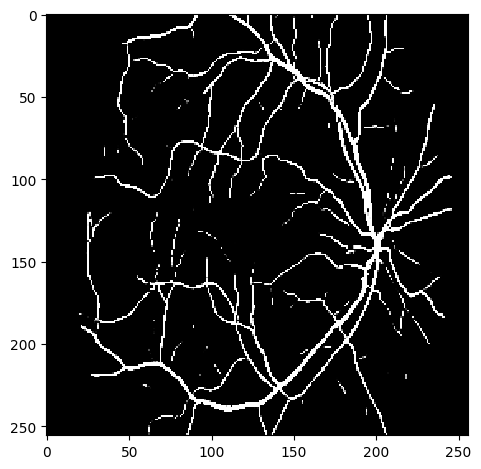

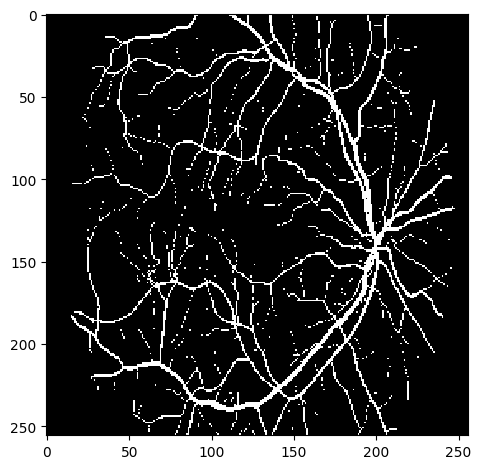

In [16]:
Y_pred = model.predict(X_test)
imshow(Y_pred[0])
plt.show()
imshow(Y_test[0])
plt.show()

In [17]:
results = model.evaluate(X_test, Y_test, verbose=1)
print(results)

1/1 [==============================] - 0s 2ms/step - loss: 0.2157 - dice_coef: 0.7843 - iou: 0.6452 - accuracy: 0.2124 - recall: 0.7691 - precision: 0.8019
[0.215659499168396, 0.784340500831604, 0.6451976299285889, 0.2123710662126541, 0.7690700888633728, 0.8019149899482727]
